<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_01_25_exp_6_naver_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##데이터, 라이브러리 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip list | grep gensim

Mounted at /content/drive
gensim                        3.6.0


In [ ]:
import pandas as pd

train_data = pd.read_table('/content/drive/MyDrive/aiffel/sentimental_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/aiffel/sentimental_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_data['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [ ]:
#!wget https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
# !cd /content/drive/MyDrive/aiffel/sentimental_classification/mecab-0.996-ko-0.9.2/
# !./configure
# !make
# !sudo make install

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3


     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 46.7 MB/s 
     |████████████████████████████████| 88 kB 5.6 MB/s 
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2687404 sha256=8982d67feb0aeed5c6cdd7224e5d3ec434193e9c837e011964689f1dfed84f11
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built JPype1-py3


In [ ]:
# install mecab-ko
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/drive/MyDrive/aiffel/sentimental_classification/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

##문장 전처리, encoding, decoding

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
def get_encoded_sentence(sentence,word_to_index):
  return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences,word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text] #단어 토큰을 의미
num_tokens = np.array(num_tokens)

print('meanlen: ', np.mean(num_tokens))
print('maxlen: ', np.max(num_tokens))
print('stdlen: ', np.std(num_tokens))

meanlen:  15.969376315021577
maxlen:  116
stdlen:  12.843535456326455


In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_ maxlen is: ',maxlen)
print('{}% of whole sentences is included.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

pad_ maxlen is:  41
93.42988343341575% of whole sentences is included.


In [ ]:
word_to_index['<PAD>'] = 0

In [ ]:
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre',maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre',maxlen=maxlen)
print(X_train.shape)

(146182, 41)


#word2vec 임베딩 활용 전

##LSTM 모델

In [ ]:
vocab_size = 10000
word_vector_dim = 16

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_val = X_train[:60000]
y_val = y_train[:60000]

partial_x_train = X_train[60000:]
partial_y_train = y_train[60000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(86182, 41)
(86182,)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val,y_val), verbose=1)

Epoch 1/20
169/169 [==============================] - 11s 20ms/step - loss: 0.5638 - accuracy: 0.7391 - val_loss: 0.3997 - val_accuracy: 0.8317
Epoch 2/20
169/169 [==============================] - 3s 16ms/step - loss: 0.3606 - accuracy: 0.8487 - val_loss: 0.3580 - val_accuracy: 0.8466
Epoch 3/20
169/169 [==============================] - 3s 16ms/step - loss: 0.3243 - accuracy: 0.8663 - val_loss: 0.3592 - val_accuracy: 0.8453
Epoch 4/20
169/169 [==============================] - 3s 16ms/step - loss: 0.3092 - accuracy: 0.8724 - val_loss: 0.3584 - val_accuracy: 0.8457
Epoch 5/20
169/169 [==============================] - 3s 16ms/step - loss: 0.2980 - accuracy: 0.8786 - val_loss: 0.3629 - val_accuracy: 0.8439
Epoch 6/20
169/169 [==============================] - 3s 16ms/step - loss: 0.2912 - accuracy: 0.8814 - val_loss: 0.3663 - val_accuracy: 0.8442
Epoch 7/20
169/169 [==============================] - 3s 16ms/step - loss: 0.2846 - accuracy: 0.8844 - val_loss: 0.3679 - val_accuracy: 0.843

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 6s - loss: 0.4555 - accuracy: 0.8303 - 6s/epoch - 4ms/step
[0.4555146396160126, 0.8302785158157349]


In [ ]:
history_dict = history.history #fitting 중 loss,accuracy 등이 매 epoch 마다 history에 저장
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


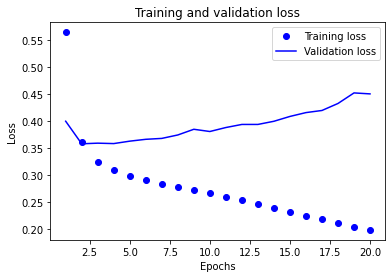

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

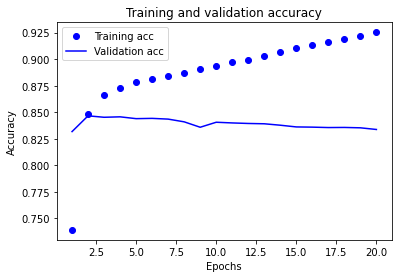

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##1-D CNN

In [ ]:
vocab_size = 10
word_to_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16,7,activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16,7,activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160       
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [ ]:
x_val = X_train[:60000]
y_val = y_train[:60000]

partial_x_train = X_train[60000:]
partial_y_train = y_train[60000:]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val,y_val), verbose=1)

Epoch 1/20
169/169 [==============================] - 9s 15ms/step - loss: 0.6912 - accuracy: 0.5245 - val_loss: 0.6889 - val_accuracy: 0.5409
Epoch 2/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6872 - accuracy: 0.5450 - val_loss: 0.6861 - val_accuracy: 0.5486
Epoch 3/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6851 - accuracy: 0.5518 - val_loss: 0.6852 - val_accuracy: 0.5505
Epoch 4/20
169/169 [==============================] - 2s 13ms/step - loss: 0.6837 - accuracy: 0.5552 - val_loss: 0.6847 - val_accuracy: 0.5529
Epoch 5/20
169/169 [==============================] - 2s 13ms/step - loss: 0.6823 - accuracy: 0.5593 - val_loss: 0.6844 - val_accuracy: 0.5539
Epoch 6/20
169/169 [==============================] - 2s 13ms/step - loss: 0.6815 - accuracy: 0.5619 - val_loss: 0.6845 - val_accuracy: 0.5559
Epoch 7/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6802 - accuracy: 0.5652 - val_loss: 0.6841 - val_accuracy: 0.5567

1537/1537 - 4s - loss: 0.6866 - accuracy: 0.5559 - 4s/epoch - 3ms/step
[0.6865794062614441, 0.5558923482894897]


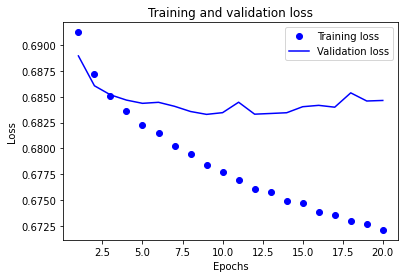

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

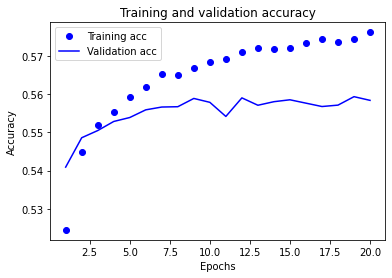

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##LSTM

In [ ]:
vocab_size = 10
word_to_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) #가장 많이 쓰이는 레이어, 벡터 수 변경 가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val,y_val), verbose=1)

Epoch 1/20
169/169 [==============================] - 5s 19ms/step - loss: 0.6922 - accuracy: 0.5199 - val_loss: 0.6905 - val_accuracy: 0.5331
Epoch 2/20
169/169 [==============================] - 3s 17ms/step - loss: 0.6896 - accuracy: 0.5363 - val_loss: 0.6886 - val_accuracy: 0.5392
Epoch 3/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6886 - accuracy: 0.5387 - val_loss: 0.6892 - val_accuracy: 0.5338
Epoch 4/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6882 - accuracy: 0.5398 - val_loss: 0.6879 - val_accuracy: 0.5428
Epoch 5/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6877 - accuracy: 0.5418 - val_loss: 0.6877 - val_accuracy: 0.5454
Epoch 6/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6874 - accuracy: 0.5449 - val_loss: 0.6875 - val_accuracy: 0.5414
Epoch 7/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6869 - accuracy: 0.5467 - val_loss: 0.6872 - val_accuracy: 0.5443

1537/1537 - 8s - loss: 0.6864 - accuracy: 0.5485 - 8s/epoch - 5ms/step
[0.6863816380500793, 0.5484874844551086]


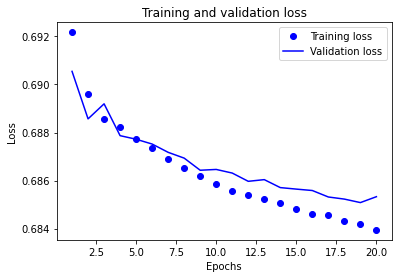

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

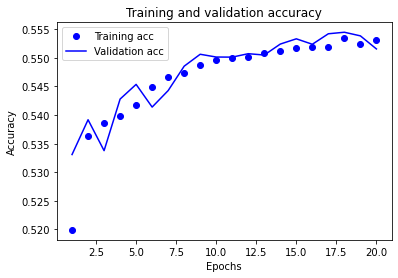

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##MaxPooling 레이어 하나

In [ ]:
vocab_size = 10
word_to_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 300)         3000      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_38 (Dense)            (None, 8)                 2408      
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,417
Trainable params: 5,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val,y_val), verbose=1)

Epoch 1/20
169/169 [==============================] - 3s 16ms/step - loss: 0.6898 - accuracy: 0.5394 - val_loss: 0.6879 - val_accuracy: 0.5457
Epoch 2/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6878 - accuracy: 0.5466 - val_loss: 0.6874 - val_accuracy: 0.5468
Epoch 3/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6872 - accuracy: 0.5463 - val_loss: 0.6872 - val_accuracy: 0.5450
Epoch 4/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6870 - accuracy: 0.5478 - val_loss: 0.6873 - val_accuracy: 0.5476
Epoch 5/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6866 - accuracy: 0.5487 - val_loss: 0.6876 - val_accuracy: 0.5438
Epoch 6/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6865 - accuracy: 0.5480 - val_loss: 0.6867 - val_accuracy: 0.5478
Epoch 7/20
169/169 [==============================] - 2s 12ms/step - loss: 0.6865 - accuracy: 0.5485 - val_loss: 0.6866 - val_accuracy: 0.5479

1537/1537 - 6s - loss: 0.6876 - accuracy: 0.5440 - 6s/epoch - 4ms/step
[0.6876235008239746, 0.5439713597297668]


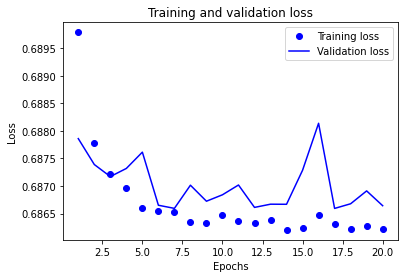

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

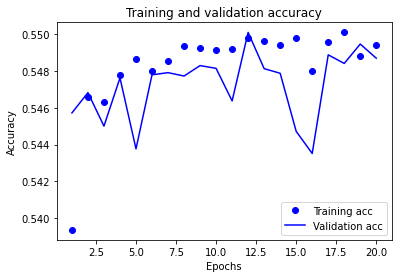

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#word2vec 임베딩 활용 후

In [ ]:
!pip list | grep gensim

gensim                        3.6.0


In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #shape: (vocab_size, embedding_dim)

(10, 16)


In [ ]:
word2vec_file_path = '/content/drive/MyDrive/aiffel/sentimental_classification/data/word2vec_2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4,word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다?

vectors = model.get_weights()[0]
for i in range(4,vocab_size): #단어 개수에서 특수문자 4개 제외하고 워드 벡터 파일에 기록
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str,list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word2vec_path = '/content/drive/MyDrive/aiffel/sentimental_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000) #100만개만 로드

In [ ]:
vocab_size = 10000 #어휘사전 크기
word_vector_dim = 300 #워드벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
  if index_to_word[i] in word2vec:
    embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
vocab_size = 10
word_to_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) #가장 많이 쓰이는 레이어, 벡터 수 변경 가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

##LSTM

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True))
model.add(tf.keras.layers.LSTM(32)) #가장 많이 쓰이는 레이어, 벡터 수 변경 가능
#model.add(tf.keras.layers.Dense(32, activation='relu'))
#model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 41, 300)           3000000   
                                                                 
 lstm_30 (LSTM)              (None, 32)                42624     
                                                                 
 dense_74 (Dense)            (None, 8)                 264       
                                                                 
 dense_75 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,042,897
Trainable params: 3,042,897
Non-trainable params: 0
_________________________________________________________________


##1-D CNN

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True))
#trainable = True : Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16,7,activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
#model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

##1-MaxPooling

In [ ]:
vocab_size = 10000
word_to_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(61, activation='relu'))
#model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, None, 300)         3000000   
                                                                 
 global_max_pooling1d_13 (Gl  (None, 300)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_68 (Dense)            (None, 4)                 1204      
                                                                 
 dense_69 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,001,209
Trainable params: 3,001,209
Non-trainable params: 0
_________________________________________________________________


##Result

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10

history = model.fit(partial_x_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(x_val,y_val),verbose=1)

Epoch 1/10
169/169 [==============================] - 7s 31ms/step - loss: 0.5553 - accuracy: 0.7074 - val_loss: 0.4116 - val_accuracy: 0.8183
Epoch 2/10
169/169 [==============================] - 4s 23ms/step - loss: 0.3757 - accuracy: 0.8392 - val_loss: 0.3645 - val_accuracy: 0.8422
Epoch 3/10
169/169 [==============================] - 4s 23ms/step - loss: 0.3238 - accuracy: 0.8648 - val_loss: 0.3672 - val_accuracy: 0.8386
Epoch 4/10
169/169 [==============================] - 4s 27ms/step - loss: 0.3061 - accuracy: 0.8728 - val_loss: 0.3518 - val_accuracy: 0.8491
Epoch 5/10
169/169 [==============================] - 4s 23ms/step - loss: 0.2804 - accuracy: 0.8861 - val_loss: 0.3549 - val_accuracy: 0.8484
Epoch 6/10
169/169 [==============================] - 5s 27ms/step - loss: 0.2602 - accuracy: 0.8966 - val_loss: 0.3642 - val_accuracy: 0.8454
Epoch 7/10
169/169 [==============================] - 4s 23ms/step - loss: 0.2438 - accuracy: 0.9051 - val_loss: 0.3790 - val_accuracy: 0.8429

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 7s - loss: 0.4254 - accuracy: 0.8380 - 7s/epoch - 4ms/step
[0.42540547251701355, 0.8380088210105896]


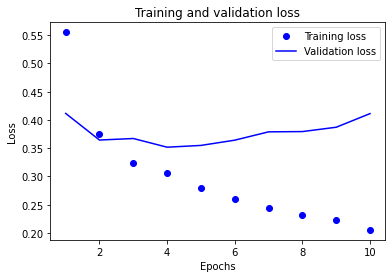

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

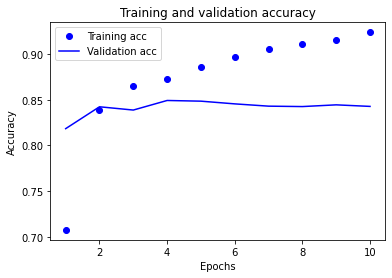

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##회고
1. 한국어 word2vec 임베딩을 활용해서 accuracy는 높였으나 오버피팅은 거의 그대로
2. 마지막 result는 LSTM 이고 다른 모델들도 결과는 비슷했다.(최악은 MaxPooling 레이어 1개 들어간 모델)
3. NLP에 대해 잘은 모르지만 한국어가 영어보다 훈련하기 어렵지 않을까 생각해본다.